# Colab Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/radistoubalidis/JSRepair.git

!python -m pip install lightning
!pip install datasets
!pip install python-dotenv
!pip install rouge-score
!pip install diff-match-patch
!pip install gspread google-auth

Cloning into 'JSRepair'...
remote: Enumerating objects: 524, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 524 (delta 26), reused 22 (delta 13), pack-reused 484 (from 1)
Receiving objects: 100% (524/524), 1.92 MiB | 2.74 MiB/s, done.
Resolving deltas: 100% (358/358), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━

In [2]:
%cd ./JSRepair

/content/JSRepair


# Dependencies

In [3]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import Any
from sklearn.model_selection import train_test_split
from modules.filters import add_labels
import os
import pandas as pd
import sqlite3
from modules.TrainConfig import init_logger, init_checkpoint, Trainer
from modules.datasets import CodeT5Dataset
from diff_match_patch import diff_match_patch
from transformers import RobertaTokenizer
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from transformers import default_data_collator
from modules.models import CodeT5
from lightning import Trainer as plTrainer

In [4]:
HF_DIR = 'Salesforce/codet5-base'
TOKENIZER_MAX_LENGTH = 512 #int(input('Tokenizer Max length: '))
DB_PATH = 'commitpack-datasets.db' if os.path.exists('commitpack-datasets.db') else '/content/drive/MyDrive/Thesis/commitpack-datasets.db'
DB_TABLE = 'commitpackft_classified_train'
if not os.path.exists(DB_PATH):
    raise RuntimeError('sqlite3 path doesnt exist.')
VAL_SIZE = 0.3
LOG_PATH = 'logs' if os.path.exists('logs') else '/content/drive/MyDrive/Thesis/logs'
VERSION = int(input('Training version: '))
LOAD_FROM_CPKT = input("Load from existing model (type cpkt path if true): ")
DEBUG = True if int(input('Debug Run (1,0): ')) == 1 else False
BATCH_SIZE = 8 if DEBUG is True else 64
CPKT_PATH = 'checkpoints' if os.path.exists('checkpoints') else '/content/drive/MyDrive/Thesis/checkpoints'
DROPOUT_RATE = float(input('Type dropout rate for classifier: '))
NUM_EPOCHS = int(input('Type number of train epochs: '))
WITH_LAYER_NORM = True
WITH_ACTIVATION = True
LEARNING_RATE = float(input("Type initial lr,(default = 1e-3): "))
BIMODAL_TRAIN = True if int(input('Combine commit messages with codes (1,0): ')) == 1 else False
NEW_CPKT = True if int(input('Save to new checkpoint path (1,0): ')) == 1 else False

classLabels = {
        "functionality" : 0.,
        "ui-ux" : 0.,
        "compatibility-performance" : 0.,
        "network-security" : 0.,
        "general": 0.
    }

num_classes = len(classLabels.keys())
modelSize = HF_DIR.split('-')[-1]
MODEL_DIR = f"CodeT5_{modelSize}_JS_{num_classes}classes_{TOKENIZER_MAX_LENGTH}MaxL"
con = sqlite3.connect(DB_PATH)

Training version: 906
Load from existing model (type cpkt path if true): /content/drive/MyDrive/Thesis/checkpoints/CodeT5_base_JS_5classes_512MaxL_v906.ckpt
Debug Run (1,0): 0
Type dropout rate for classifier: 0.45
Type number of train epochs: 10
Type initial lr,(default = 1e-3): 1e-2
Combine commit messages with codes (1,0): 0
Save to new checkpoint path (1,0): 0


# Training

## Create Classification Labels

```json
{
    "mobile" : 0,
    "functionality" : 0,
    "ui-ux" : 0,
    "compatibility-performance" : 0,
    "network-security" : 0,
    "general": 0
}

Ένα δείγμα που κατηγοριοποιήθηκε ως σφάλμα λειτουργικότητας(functionality) και ui-ux θα έχει διάνυσμα ταξινόμησης ->
[0,1,1,0,0,0]
```


In [5]:
ds_df = pd.read_sql_query("select * from commitpackft_classified_train", con)
ds_df['class_labels'] = ds_df['bug_type'].apply(lambda bT: add_labels(bT.split(','), classLabels))

ds_df = ds_df[ds_df['bug_type'] != 'mobile']
ds_df = ds_df[ds_df['old_contents'].str.len() > 0]

if DEBUG:
    ds_df = ds_df.sample(20)

## Data Preprocess

### Filter out outliers

In [6]:
def count_comment_lines(sample: str) -> int:
    comment_blocks = []
    start_index = -1
    for i, line in enumerate(sample.splitlines()):
        if line.strip().startswith('/*'):
            start_index = i
        elif line.strip().endswith('*/'):
            comment_blocks.append([start_index, i])
            start_index = -1

    comment_lines_count = sum([c[1]-c[0] for c in comment_blocks])

    for i, line in enumerate(sample.splitlines()):
        if line.strip().startswith('//'):
            comment_lines_count += 1
    return comment_lines_count

ds_df['old_contents_comment_lines_count'] = ds_df['old_contents'].apply(lambda sample: count_comment_lines(sample))
ds_df['new_contents_comment_lines_count'] = ds_df['new_contents'].apply(lambda sample: count_comment_lines(sample))

# Filter out samples where the sum of comment lines increased more than 3 lines
# to prevent excessive masking
ds_df = ds_df[abs(ds_df['old_contents_comment_lines_count'] - ds_df['new_contents_comment_lines_count']) <= 3]
# Filter out samples with more than 10 comment lines
ds_df = ds_df[(ds_df['old_contents_comment_lines_count'] < 10) & (ds_df['new_contents_comment_lines_count'] < 10)]

dmp = diff_match_patch()

def compute_diffs(sample: dict):
    # Compute the differences
    diffs = dmp.diff_main(sample['old_contents'], sample['new_contents'])
    dmp.diff_cleanupSemantic(diffs)
    # Count the changes
    return sum(1 for diff in diffs if diff[0] == 1)  # 0 means no change

ds_df['num_changes'] = ds_df.apply(lambda sample: compute_diffs(sample), axis=1)

# Filter out samples with more than 3 changes in the code
ds_df = ds_df[ds_df['num_changes'] <= 3]

# filter out samples with more than 50 lines of code
ds_df = ds_df[(ds_df['old_contents'].str.count('\n') <= 50) & (ds_df['new_contents'].str.count('\n') <= 50)]

# filter out samples with more than 2 bug types
ds_df = ds_df[ds_df['bug_type'].str.count(',') < 2]
print(f"Total training samples after filtering: {len(ds_df)}")

Total training samples after filtering: 6638


### Concatenate Commit Message with the old contents
- This way, the commit message is directly provided as additional context, and the models (T5, Bert) can process both the buggy code and the commit message in a unified manner.
- This approach will allow the model to learn the relationship between the commit message and the changes made to the code.

In [7]:
tokenizer = RobertaTokenizer.from_pretrained(HF_DIR)
old_codes = ds_df[['message', 'old_contents', 'class_labels']]
new_codes = ds_df[['message', 'new_contents', 'class_labels']]
if BIMODAL_TRAIN:
    old_codes['input_seq'] = '/* ' + old_codes['message'] + '*/\n' + tokenizer.sep_token + '\n' + old_codes['old_contents']
    new_codes['output_seq'] = '/* ' + new_codes['message'] + '*/\n' + tokenizer.sep_token + '\n' + new_codes['new_contents']
else:
    old_codes['input_seq'] = old_codes['old_contents'].copy()
    new_codes['output_seq'] = new_codes['new_contents'].copy()

TRAIN_old, VAL_old, TRAIN_new, VAL_new = train_test_split(old_codes, new_codes, test_size=VAL_SIZE, random_state=42)

print(f"Total training samples: {len(TRAIN_old)}")
print(f"Total validation samples: {len(VAL_old)}")

Total training samples: 4646
Total validation samples: 1992


<ipython-input-7-23b72b160dc9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_codes['input_seq'] = old_codes['old_contents'].copy()
<ipython-input-7-23b72b160dc9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_codes['output_seq'] = new_codes['new_contents'].copy()


## Prepare Model Input

In [8]:
TOKENIZER_MAX_LENGTH = 512

TRAIN_encodings = tokenizer(
    TRAIN_old['input_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

VAL_encodings = tokenizer(
    VAL_old['input_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

TRAIN_decodings = tokenizer(
    TRAIN_new['output_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

VAL_decodings = tokenizer(
    VAL_new['output_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

TRAIN_classes = torch.tensor(TRAIN_old['class_labels'].tolist())
VAL_classes = torch.tensor(VAL_old['class_labels'].tolist())



TRAIN_dataset = CodeT5Dataset(TRAIN_encodings, TRAIN_decodings, TRAIN_classes)
VAL_dataset = CodeT5Dataset(VAL_encodings, VAL_decodings, VAL_classes)


# Class weights
# pos_weight[i] = (Number of negative samples for class i) / (Number of positive samples for class i)
num_samples = TRAIN_classes.size(0)
num_classes = TRAIN_classes.size(1)

pos_counts = torch.sum(TRAIN_classes, dim=0)
neg_counts = num_samples - pos_counts
class_weights = neg_counts / (pos_counts + 1e-6)
class_weights = class_weights.numpy()

## Initialize Training Settings

In [9]:
logger = init_logger(log_path=LOG_PATH, model_dir=MODEL_DIR, version=VERSION)
checkpoint = init_checkpoint(cpkt_path=CPKT_PATH, model_dir=MODEL_DIR, version=VERSION, targetMetric='val_auxilary_loss')
trainer = Trainer(checkpoint,logger,debug=DEBUG, num_epochs=NUM_EPOCHS, precision='32-true')

if len(LOAD_FROM_CPKT) > 0 and os.path.exists(LOAD_FROM_CPKT):
    model = CodeT5.load_from_checkpoint(
        LOAD_FROM_CPKT,
        class_weights=class_weights,
        model_dir=HF_DIR,
        num_classes=num_classes,
        dropout_rate=DROPOUT_RATE,
        with_activation=True,
        with_layer_norm=True,
        lr=LEARNING_RATE
    )
else:
    model = CodeT5(
        class_weights=class_weights,
        model_dir=HF_DIR,
        num_classes=num_classes,
        dropout_rate=DROPOUT_RATE,
        with_activation=True,
        with_layer_norm=True,
        lr=LEARNING_RATE
    )

model.model.train()
model.classifier.train()

if DEBUG:
    model.to('cpu')

dataloader = DataLoader(TRAIN_dataset, batch_size=BATCH_SIZE,num_workers=14, shuffle=True, collate_fn=default_data_collator)
val_dataloader = DataLoader(VAL_dataset, batch_size=BATCH_SIZE, num_workers=14, collate_fn=default_data_collator)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Run Training

In [10]:
if len(LOAD_FROM_CPKT) > 0 and os.path.exists(LOAD_FROM_CPKT) and not NEW_CPKT:
    trainer.fit(
        model,
        train_dataloaders=dataloader,
        val_dataloaders=val_dataloader,
        ckpt_path=LOAD_FROM_CPKT
    )
else:
    trainer.fit(
        model,
        train_dataloaders=dataloader,
        val_dataloaders=val_dataloader
    )

INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Thesis/checkpoints exists and is not empty.
INFO: Restoring states from the checkpoint pat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Training: |          | 0/? [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 146: 'val_auxilary_loss' reached 0.42516 (best 0.42516), saving model to '/content/drive/MyDrive/Thesis/checkpoints/CodeT5_base_JS_5classes_512MaxL_v906-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 146: 'val_auxilary_loss' reached 0.42516 (best 0.42516), saving model to '/content/drive/MyDrive/Thesis/checkpoints/CodeT5_base_JS_5classes_512MaxL_v906-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 219: 'val_auxilary_loss' reached 0.41543 (best 0.41543), saving model to '/content/drive/MyDrive/Thesis/checkpoints/CodeT5_base_JS_5classes_512MaxL_v906-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 219: 'val_auxilary_loss' reached 0.41543 (best 0.41543), saving model to '/content/drive/MyDrive/Thesis/checkpoints/CodeT5_base_JS_5classes_512MaxL_v906-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 292: 'val_auxilary_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 292: 'val_auxilary_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 365: 'val_auxilary_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 365: 'val_auxilary_loss' was not in top 1


## Save Model Config to CSV

In [12]:
if not DEBUG:
    import gspread
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    from google.auth import default

    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    spreadsheet = gc.open("model-configs").sheet1
    modelConfig = {
            'name': MODEL_DIR,
            'tokenizer_max_length': TOKENIZER_MAX_LENGTH,
            'num_classes': num_classes,
            'dropout_rate': DROPOUT_RATE,
            'with_activation': WITH_ACTIVATION,
            'with_layer_norm': WITH_LAYER_NORM,
            'learning_rate': LEARNING_RATE,
            'bimodal_train': BIMODAL_TRAIN
    }
    spreadsheet.append_row(list(modelConfig.values()))

# Testing

## Load Test Dataset

In [11]:
test_df = pd.read_sql_query('select * from commitpackft_classified_test', con)
test_df['class_labels'] = test_df['bug_type'].apply(lambda bT: add_labels(bT, classLabels))

test_df = test_df[test_df['bug_type'] != 'mobile']
test_df['input_seq'] = test_df['message'] + ' ' + model.tokenizer.sep_token + ' ' + test_df['old_contents']
test_df['output_seq'] = test_df['message'] + ' ' + model.tokenizer.sep_token + ' ' + test_df['new_contents']

if DEBUG:
    test_df = test_df.iloc[:10]

test_df.head()

,index,commit,old_file,new_file,old_contents,new_contents,subject,message,lang,license,repos,processed_message,is_bug,bug_type,class_labels,input_seq,output_seq
0,48968,4d949a2bc8f628dcc66ee62161ae3680b21766d0,bin/pep-proxy.js,bin/pep-proxy.js,#!/usr/bin/env node\n\nvar proxy = require('.....,#!/usr/bin/env node\n\nvar proxy = require('.....,FIX Move the module definition to the top of t...,FIX Move the module definition to the top of t...,JavaScript,agpl-3.0,"telefonicaid/fiware-pep-steelskin,telefonicaid...",fix move modul definit top function,1,functionality,"[1.0, 0.0, 0.0, 0.0, 0.0]",FIX Move the module definition to the top of t...,FIX Move the module definition to the top of t...
1,21631,58c6907562ca3d4e943dfed56e795ae0a9cde762,lib/cache/lib/processUndefined.js,lib/cache/lib/processUndefined.js,"export default (doc, fields) => {\n fields....","export default (doc, fields) => {\n fields....",Fix for undefined on nested fields,Fix for undefined on nested fields\n,JavaScript,mit,cult-of-coders/redis-oplog,fix undefin nest field,1,ui-ux,"[0.0, 1.0, 0.0, 0.0, 0.0]",Fix for undefined on nested fields\n </s> expo...,Fix for undefined on nested fields\n </s> expo...
2,38478,54bc7736bc5d3381a48eebba476f0933884899c6,lib/errorMessages.js,lib/errorMessages.js,"""use strict"";\n\nmodule.exports = {\n loadU...","""use strict"";\n\nmodule.exports = {\n loadU...",Clean up some error message.,Clean up some error message.\n,JavaScript,mit,YuzuJS/storeit,clean error messag,1,general,"[0.0, 0.0, 0.0, 0.0, 1.0]","Clean up some error message.\n </s> ""use stric...","Clean up some error message.\n </s> ""use stric..."
3,45690,2f3f141e1196eaa39ade102d3795cd189f57828f,src/IconMenu/IconMenu.js,src/IconMenu/IconMenu.js,import React from 'react'\nimport PropTypes fr...,import React from 'react'\nimport PropTypes fr...,Rename prop name => iconName,refactor(components): Rename prop name => icon...,JavaScript,mit,"dimik/react-material-web-components,dimik/reac...",refactorcompon renam prop name = iconnam,1,general,"[0.0, 0.0, 0.0, 0.0, 1.0]",refactor(components): Rename prop name => icon...,refactor(components): Rename prop name => icon...
4,38421,bc2e4d8ebd609461c4abc63db480ae1aa5558ff7,ghost/admin/controllers/editor/new.js,ghost/admin/controllers/editor/new.js,import EditorControllerMixin from 'ghost/mixin...,import EditorControllerMixin from 'ghost/mixin...,Fix warning about transitionTo being deprecated,Fix warning about transitionTo being deprecated\n,JavaScript,mit,"TryGhost/Ghost,TryGhost/Ghost,TryGhost/Ghost",fix warn transitionto deprec,1,general,"[0.0, 0.0, 0.0, 0.0, 1.0]",Fix warning about transitionTo being deprecate...,Fix warning about transitionTo being deprecate...


## Data Preprocessing

In [12]:
test_df['old_contents_comment_lines_count'] = test_df['old_contents'].apply(lambda sample: count_comment_lines(sample))
test_df['new_contents_comment_lines_count'] = test_df['new_contents'].apply(lambda sample: count_comment_lines(sample))

# Filter out samples where the sum of comment lines increased more than 3 lines
# to prevent excessive masking
test_df = test_df[abs(test_df['old_contents_comment_lines_count'] - test_df['new_contents_comment_lines_count']) <= 3]
# Filter out samples with more than 10 comment lines
test_df = test_df[(test_df['old_contents_comment_lines_count'] < 10) & (test_df['new_contents_comment_lines_count'] < 10)]

dmp = diff_match_patch()

def compute_diffs(sample: dict):
    # Compute the differences
    diffs = dmp.diff_main(sample['old_contents'], sample['new_contents'])
    dmp.diff_cleanupSemantic(diffs)
    # Count the changes
    return sum(1 for diff in diffs if diff[0] == 1)  # 0 means no change

test_df['num_changes'] = test_df.apply(lambda sample: compute_diffs(sample), axis=1)

# Filter out samples with more than 3 changes in the code
test_df = test_df[test_df['num_changes'] <= 3]

# filter out samples with more than 50 lines of code
test_df = test_df[(test_df['old_contents'].str.count('\n') <= 50) & (test_df['new_contents'].str.count('\n') <= 50)]

# filter out samples with more than 2 bug types
test_df = test_df[test_df['bug_type'].str.count(',') < 2]
print(f"Total test samples after filtering: {len(test_df)}")

Total test samples after filtering: 1690


## Tokenize Data

In [13]:
encoded_samples = model.tokenizer(
    test_df['input_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

encoded_labels = model.tokenizer(
    test_df['new_contents'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

labels = torch.tensor(test_df['class_labels'].tolist())

## Testing Script

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

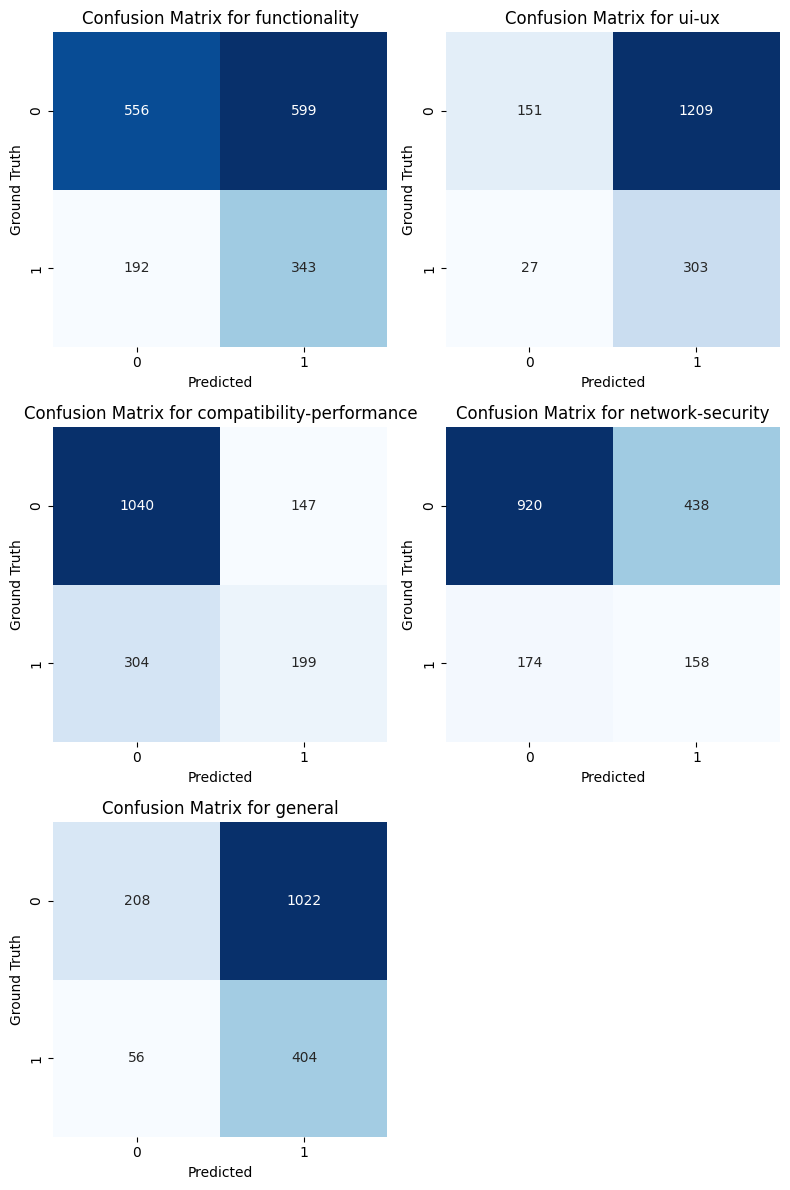

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    classification_loss    │    1.0185316801071167     │
│          t5_loss          │    0.12401758134365082    │
└───────────────────────────┴───────────────────────────┘

[{'t5_loss': 0.12401758134365082, 'classification_loss': 1.0185316801071167}]

In [14]:
METRICS_PATH = 'metrics' if os.path.exists('metrics') else '/content/drive/MyDrive/Thesis/metrics'
os.environ['METRICS_PATH'] = METRICS_PATH
os.environ['VERSION'] = str(VERSION)
MODEL_NAME = 'CodeT5'
os.environ['MODEL_NAME'] = MODEL_NAME

model.eval()

torch_ds = CodeT5Dataset(encodings=encoded_samples, decodings=encoded_labels, class_labels=labels)
loader = DataLoader(torch_ds, batch_size=1, num_workers=14)

trainer = plTrainer()
trainer.test(model=model, dataloaders=loader)

## Compute Metrics

**ROUGE (Recall-Oriented understudy for Gisting Evaluation**
- A metric for evaluation text generation/sumamrization models.
- It measures the overlap between machine generated text (prediction) and its human generated corresponding text (reference)\
- [0,1] { close to 0: poor similarity, close to 1: better similarity}
- n-gram: seq of n words

Variations
- ROUGE-N : μετράει το σύνολο της επικάλυψης *[πόσες φορές εμφανίζετε στο παραγώμενο κείμενο]* το n-gram μεταξύ των προβλέψεων και του πραγματικού κειμένου

- ROUGE-N_recall : num n gram matches / num of n-gram in reference
- ROUGE-N-precision : nummber of n-gram matches / number of n gram in prediction
- ROUGE-L : Βασίζεται στο μάκρος του μεγαλύτερης κοινής υπό-ακολουθίας (Longest Common Sequence -LCS) . Υπολογίζει το μέτρο f-measure
    - ROUGE-L_recall : LCS / num words in reference
    - ROUGE-L_precision : LCS / num words in prediction

In [15]:
from modules.metrics import CodeRouge
import json

rouge = CodeRouge(['rouge7','rouge8','rouge9','rougeL','rougeLsum'])

rouge.compute(predictions=model.generated_codes, references=test_df['new_contents'].tolist())
rouge.calc_averages()

avgs_path = f"{METRICS_PATH}/{MODEL_NAME}_v{VERSION}/rouge.json"
all_path = f"{METRICS_PATH}/{MODEL_NAME}_v{VERSION}/avg_rouge.csv"
with open(avgs_path, 'a') as f:
    json.dump(rouge.avgs, f, indent=4)

all_scores = []
for r in rouge.rouge_types:
    all_scores += rouge.rouge_type_to_list(r)

metrics_df = pd.DataFrame(all_scores)

for m in ['precision','recall','fmeasure']:
    metrics_df[m] = round(metrics_df[m], 3)
metrics_df.to_csv(all_path, index=False)

### Bar Plots

Comparison model avg ROUGE-N metrics path: /content/drive/MyDrive/Thesis/metrics/CodeT5_v903/rouge.json


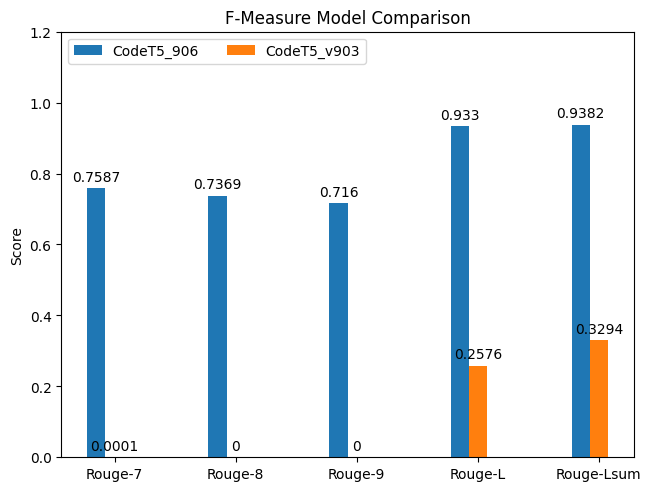

In [16]:
codebert_avgs = rouge.avgs

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model_path.split('/')[-2]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)


plot_data = {
    f"{MODEL_NAME}_{VERSION}": (round(codebert_avgs['avg_rouge7'].fmeasure, 5), round(codebert_avgs['avg_rouge8'].fmeasure, 5), round(codebert_avgs['avg_rouge9'].fmeasure, 5), round(codebert_avgs['avg_rougeL'].fmeasure, 5), round(codebert_avgs['avg_rougeLsum'].fmeasure, 5)),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}

metric_types = ('Rouge-7', 'Rouge-8','Rouge-9', 'Rouge-L', 'Rouge-Lsum')
x = np.arange(len(metric_types))
width = 0.15
multiplier = 0

fix, ax = plt.subplots(layout='constrained')


for model, values in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('F-Measure Model Comparison')
ax.set_xticks(x + width, metric_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
plt.show()

### Chart

Comparison model avg ROUGE-N metrics path: /content/drive/MyDrive/Thesis/metrics/CodeT5_v903/rouge.json


<Axes: title={'center': 'F-Measure Model Comparison'}, ylabel='Score'>

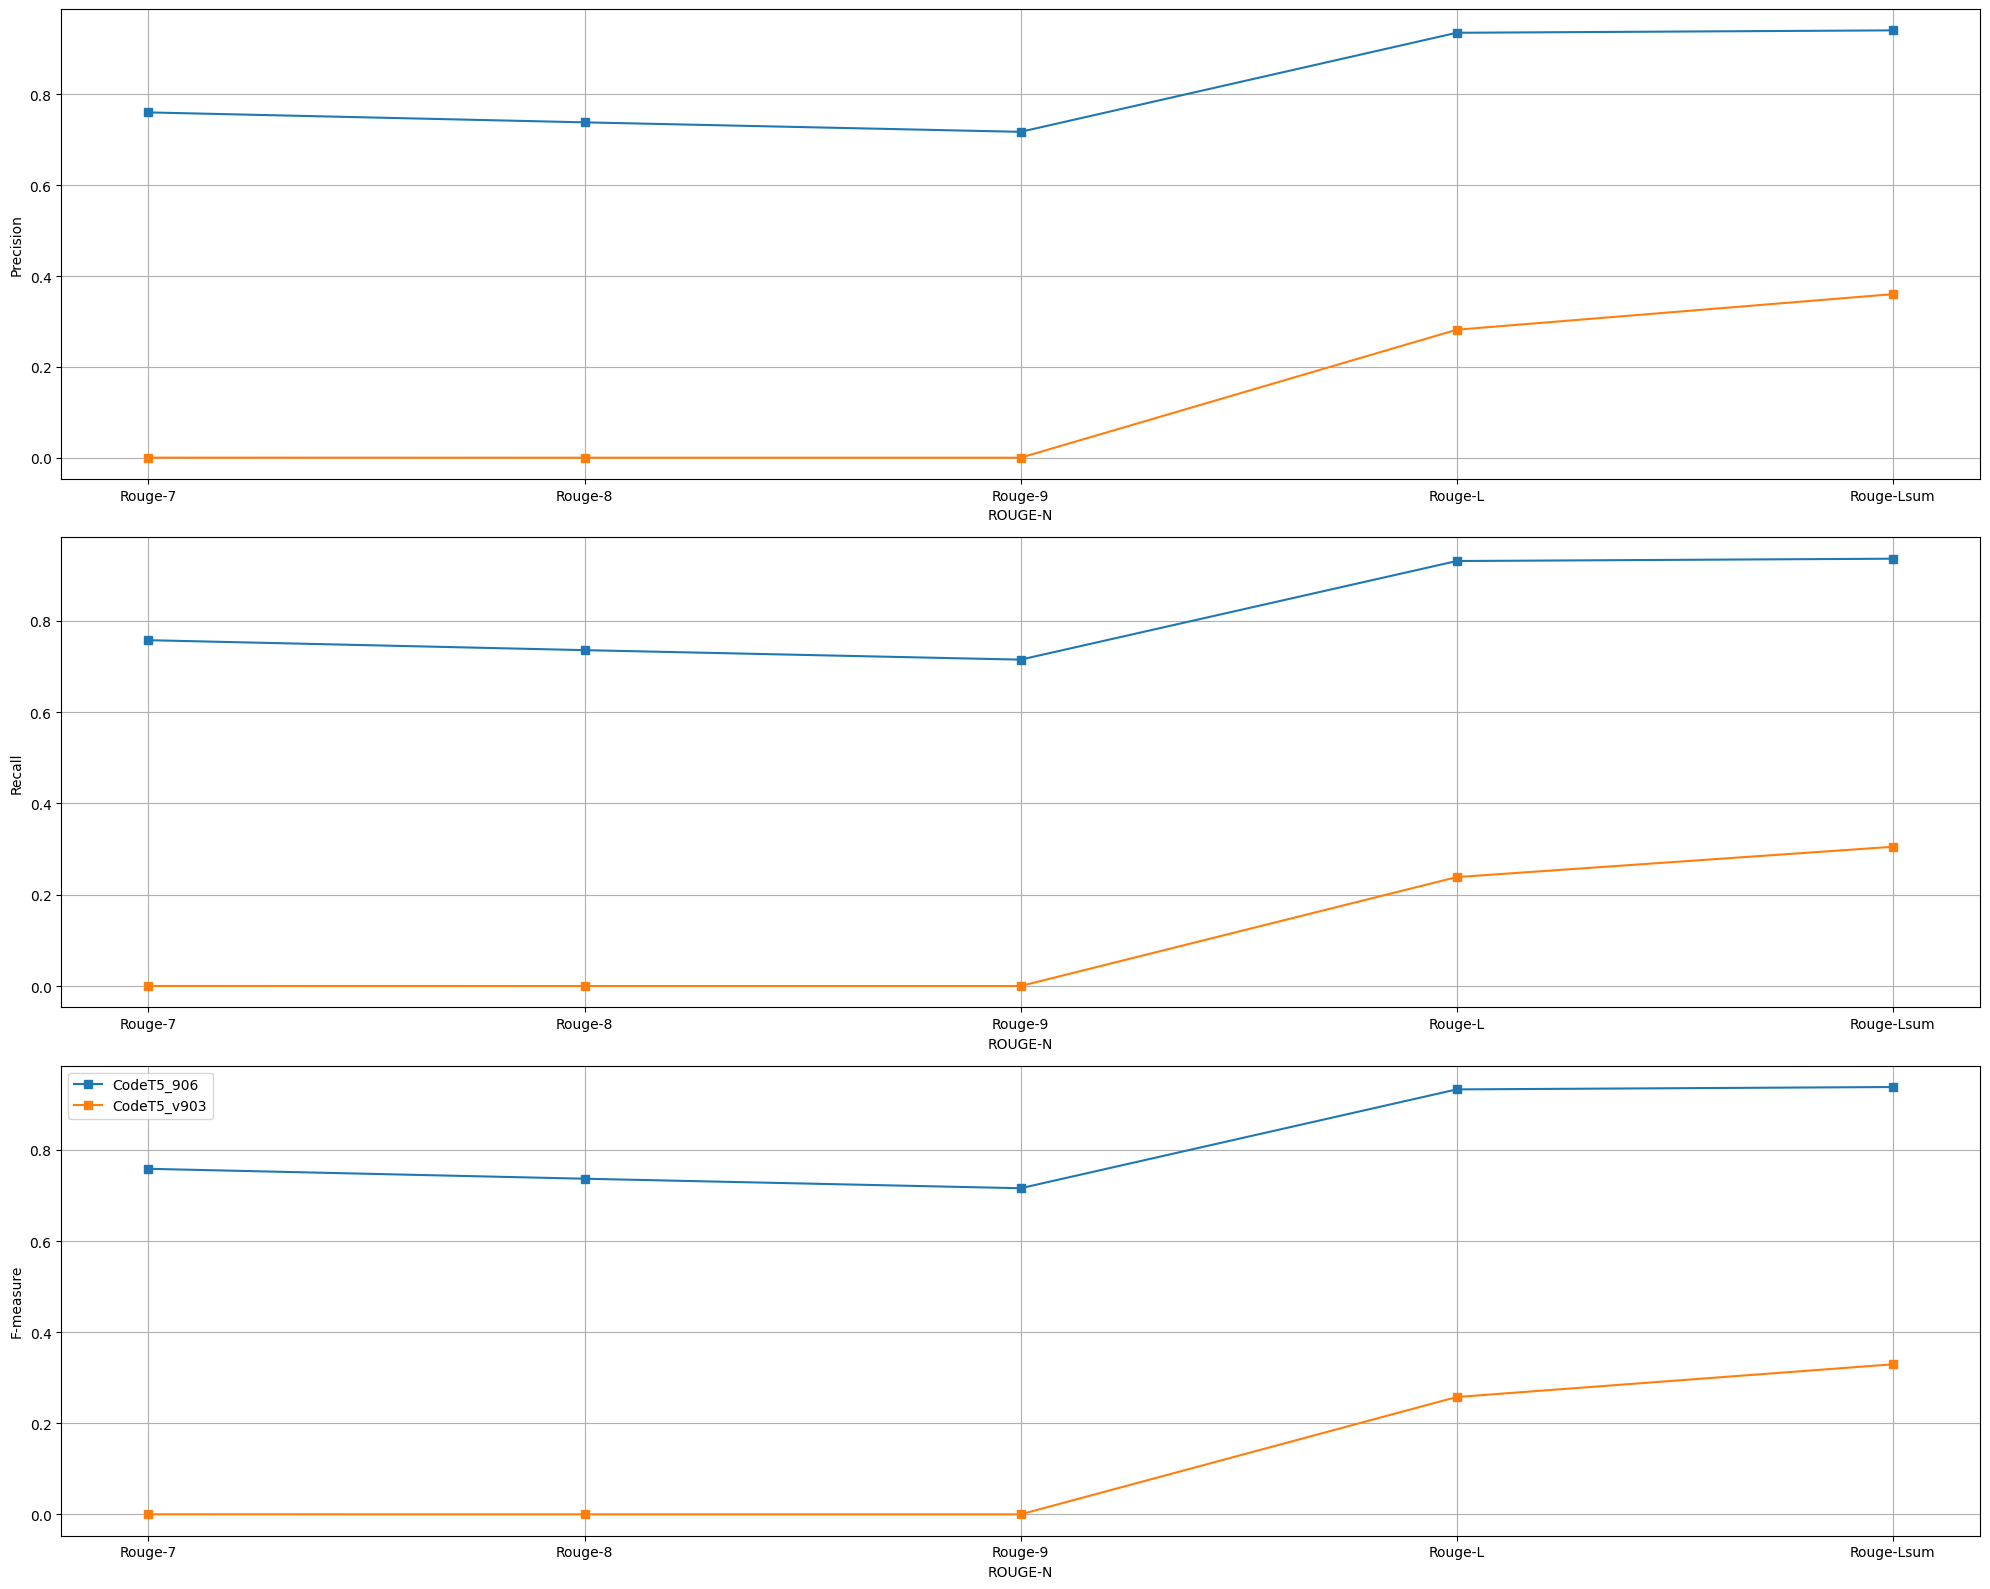

In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs  # Assuming rouge is a library/function that provides average scores

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model = comparison_model_path.split('/')[-2]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)

# Define metric types (assuming same metrics for both models)
metric_types = ('Rouge-7', 'Rouge-8', 'Rouge-9', 'Rouge-L', 'Rouge-Lsum')

# Create a figure with 3 rows (subplots) and 1 column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 16))

# Data dictionaries for each metric (assuming data structure from rouge)
precision_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].precision, codebert_avgs['avg_rouge8'].precision, codebert_avgs['avg_rouge9'].precision, codebert_avgs['avg_rougeL'].precision, codebert_avgs['avg_rougeLsum'].precision),
    comparison_model: (codet5_avgs['avg_rouge7'][0], codet5_avgs['avg_rouge8'][0], codet5_avgs['avg_rouge9'][0], codet5_avgs['avg_rougeL'][0], codet5_avgs['avg_rougeLsum'][0]),
}
recall_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].recall, codebert_avgs['avg_rouge8'].recall, codebert_avgs['avg_rouge9'].recall, codebert_avgs['avg_rougeL'].recall, codebert_avgs['avg_rougeLsum'].recall),
    comparison_model: (codet5_avgs['avg_rouge7'][1], codet5_avgs['avg_rouge8'][1], codet5_avgs['avg_rouge9'][1], codet5_avgs['avg_rougeL'][1], codet5_avgs['avg_rougeLsum'][1]),
}
f1_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].fmeasure, codebert_avgs['avg_rouge8'].fmeasure, codebert_avgs['avg_rouge9'].fmeasure, codebert_avgs['avg_rougeL'].fmeasure, codebert_avgs['avg_rougeLsum'].fmeasure),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}


# Plot Precision (ax1)
for model, precision in precision_data.items():
    ax1.plot(metric_types, precision, label=model, marker='s')  # 's' for square marker
ax1.set_xlabel('ROUGE-N')
ax1.set_ylabel('Precision')
ax1.grid(True)

# Plot Recall (ax2)
for model, recall in recall_data.items():
    ax2.plot(metric_types, recall, label=model, marker='s')  # 'o' for circle marker
ax2.set_xlabel('ROUGE-N')
ax2.set_ylabel('Recall')
ax2.grid(True)

# Plot F1 Score (ax3)
for model, f1 in f1_data.items():
    ax3.plot(metric_types, f1, label=model, marker='s')
ax3.set_xlabel('ROUGE-N')
ax3.set_ylabel('F-measure')
ax3.grid(True)

plt.legend(loc='upper left')
plt.tight_layout()

# Save the entire figure as a single PNG
plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
ax